In [ ]:
!pip install split-folders

In [25]:
!pip install ptflops 

In [1]:
import splitfolders
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time
from ptflops import get_model_complexity_info

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

%matplotlib inline

In [2]:
DATASET_DIR = r"C:\Users\patel\Downloads\Dataset\PlantVillage"

In [5]:
# Split folder into train, test and validation set.
splitfolders.ratio(r'C:\Users\patel\Downloads\Dataset\PlantVillage\\', output=r'C:\Users\patel\Downloads\Dataset\PlantVillage\\', seed=1337, ratio=(0.8, 0.1, 0.1))

Copying files: 25414 files [03:55, 107.71 files/s]


In [3]:
train_dir = DATASET_DIR + "/train"
valid_dir = DATASET_DIR + "/valid"
diseases = os.listdir(train_dir)

diseases = [item for item in diseases]

# Print dieases name
print(diseases)

['Apple___Cedar_apple_rust', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Pepper,_bell___Bacterial_spot', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Tomato_mosaic_virus']


In [4]:
print(f"Total classes are: {len(diseases)}")

Total classes are: 15


In [5]:
nums = {disease: len(os.listdir(os.path.join(train_dir, disease))) for disease in diseases}

# Converting the nums dictionary to pandas DataFrame with plant name as index and number of images as column
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of images"])

img_per_class

,No. of images
Apple___Cedar_apple_rust,220
Cherry_(including_sour)___Powdery_mildew,841
Corn_(maize)___Northern_Leaf_Blight,788
Grape___Leaf_blight_(Isariopsis_Leaf_Spot),860
Orange___Haunglongbing_(Citrus_greening),4405
Peach___Bacterial_spot,1837
"Pepper,_bell___Bacterial_spot",797
Potato___Late_blight,800
Raspberry___healthy,296
Soybean___healthy,4072


In [6]:
sum([len(os.listdir(os.path.join(train_dir, disease))) for disease in diseases])

20325

<Figure size 1000x600 with 0 Axes>

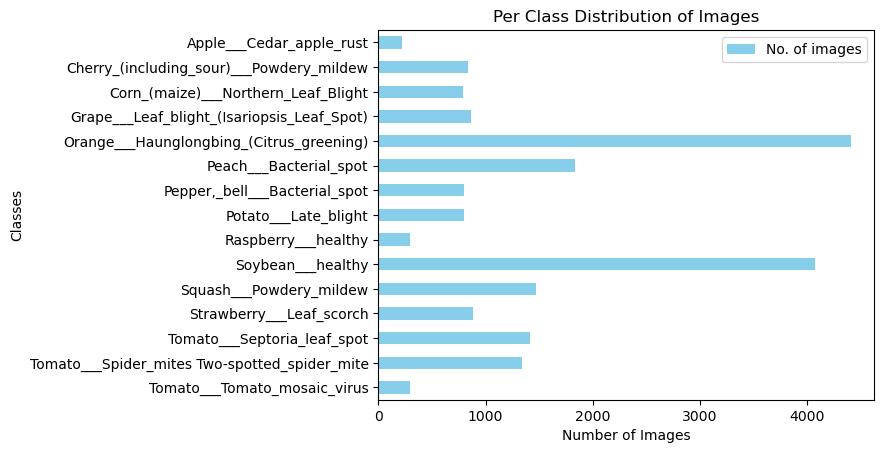

In [7]:
plt.figure(figsize=(10, 6))
img_per_class.plot(kind='barh', color='skyblue')
plt.xlabel('Number of Images')
plt.ylabel('Classes')
plt.title('Per Class Distribution of Images')
plt.gca().invert_yaxis() 
plt.show()

In [8]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
batch_size=64

In [10]:
train_dataset = ImageFolder(root=r'C:\Users\patel\Downloads\Dataset\PlantVillage\train', transform=train_transforms)
val_dataset = ImageFolder(root=r'C:\Users\patel\Downloads\Dataset\PlantVillage\val', transform=val_transforms)
test_dataset = ImageFolder(root=r'C:\Users\patel\Downloads\Dataset\PlantVillage\test', transform=val_transforms)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

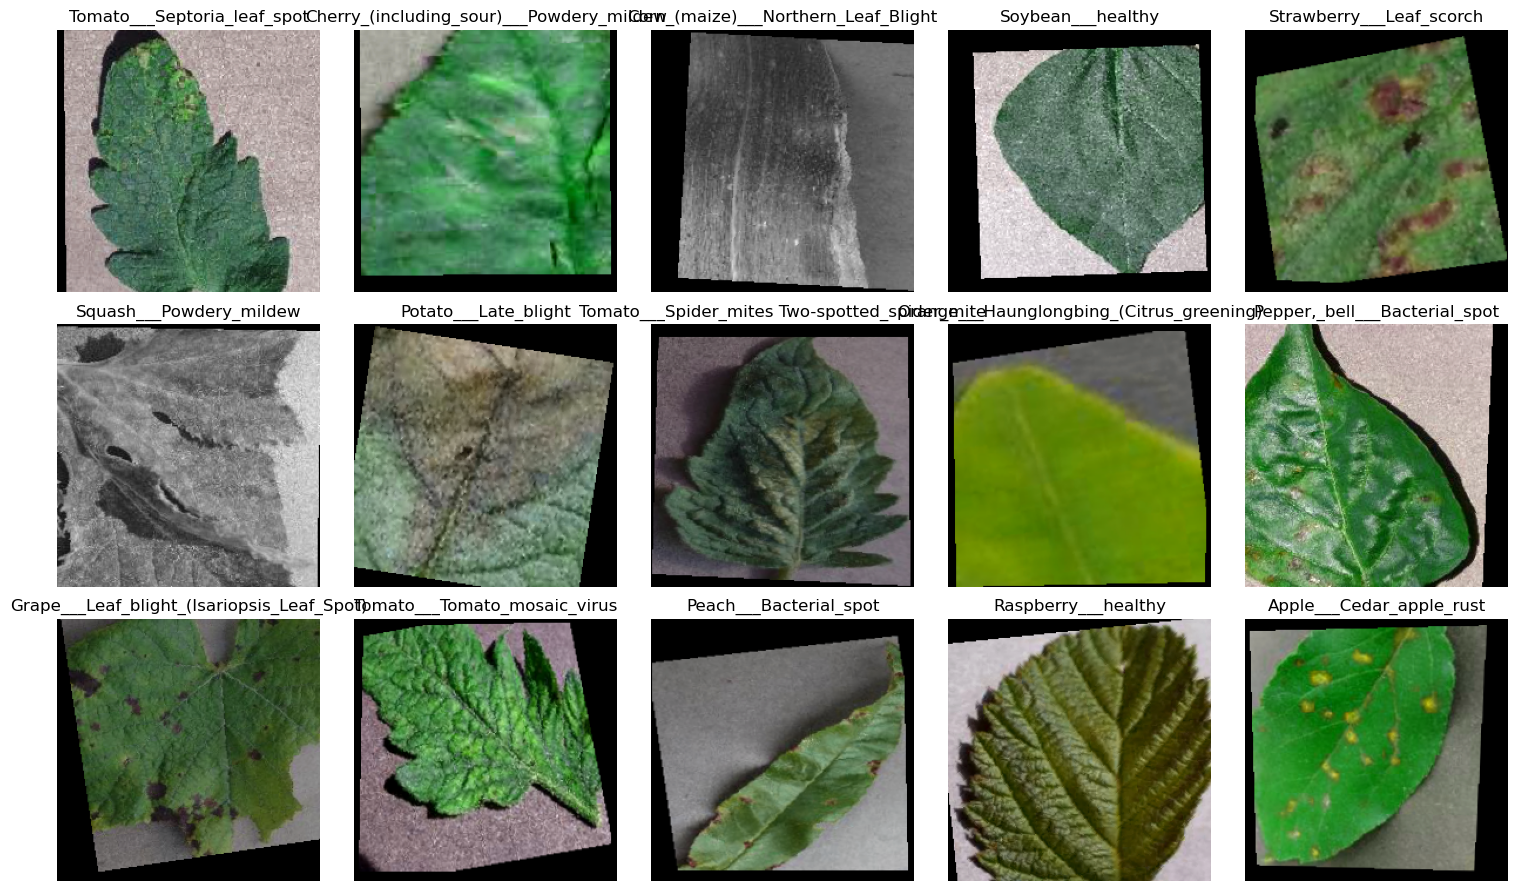

In [24]:
unique_classes = set()
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

num_classes = len(class_to_idx)
num_rows = math.ceil(num_classes/5)
num_cols = min(5, num_classes)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 3))

row_index = 0
col_index = 0

for images, labels in train_loader:
    for image, label in zip(images, labels):
        class_name = idx_to_class[label.item()]
        if class_name not in unique_classes:
            unique_classes.add(class_name)
            ax = axes[row_index, col_index]
            img = image.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis('off')

            col_index += 1
            if col_index == num_cols:
                col_index = 0
                row_index += 1

        if len(unique_classes) == num_classes:
            break
    if len(unique_classes) == num_classes:
        break

plt.tight_layout()
plt.show()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
model = models.resnet18(pretrained=True)
model.to(device)

Device: cuda


c:\Users\patel\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patel\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

c:\Users\patel\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [14]:
BEST_MODEL_PATH=r'C:\Users\patel\Downloads\Dataset\PlantVillage\ResNet18_PlantVillage.pth'

In [15]:
early_stopping_patience = 5
epochs_no_improve = 0
val_loss_min = np.Inf

In [16]:
train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

In [17]:
def train_model(num_epochs):
    global epochs_no_improve
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        # Train the model
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        start_time = time.time()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_time = time.time() - start_time
        epoch_loss = running_loss / total
        epoch_acc = correct / total

        start_time = time.time()
        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_time = time.time() - start_time
        val_loss = val_running_loss / val_total
        val_accuracy = val_correct / val_total

        scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        train_accuracy.append(epoch_acc)
        train_loss.append(epoch_loss)
        validation_accuracy.append(val_accuracy)
        validation_loss.append(val_loss)

        flops, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True, print_per_layer_stat=False)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
                f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Train time: {train_time:.4f}s, '
                f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val time: {val_time:.4f}s, '
                f'FLOPs: {flops}, Params: {params}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), BEST_MODEL_PATH)
        else:
            epochs_no_improve += 1

        if epochs_no_improve == early_stopping_patience:
            print('Early stopping initiated...')
            break

In [18]:
num_epochs = 10
train_model(num_epochs)

Epoch [1/10], Train Loss: 0.8907, Train Acc: 0.8104, Train time: 1510.3258s, Val Loss: 0.0575, Val Acc: 0.9842, Val time: 82.8572s, FLOPs: 1.83 GMac, Params: 11.69 M
Epoch [2/10], Train Loss: 0.2103, Train Acc: 0.9354, Train time: 1501.1951s, Val Loss: 0.0287, Val Acc: 0.9929, Val time: 67.9385s, FLOPs: 1.83 GMac, Params: 11.69 M
Epoch [3/10], Train Loss: 0.1645, Train Acc: 0.9472, Train time: 1494.7403s, Val Loss: 0.0238, Val Acc: 0.9921, Val time: 73.0327s, FLOPs: 1.83 GMac, Params: 11.69 M
Epoch [4/10], Train Loss: 0.1284, Train Acc: 0.9605, Train time: 1573.3081s, Val Loss: 0.0206, Val Acc: 0.9929, Val time: 34.1567s, FLOPs: 1.83 GMac, Params: 11.69 M
Epoch [5/10], Train Loss: 0.1136, Train Acc: 0.9647, Train time: 132.2354s, Val Loss: 0.0108, Val Acc: 0.9964, Val time: 23.4060s, FLOPs: 1.83 GMac, Params: 11.69 M
Epoch [6/10], Train Loss: 0.1101, Train Acc: 0.9655, Train time: 134.7162s, Val Loss: 0.0129, Val Acc: 0.9949, Val time: 38.8287s, FLOPs: 1.83 GMac, Params: 11.69 M
Epoch 

In [19]:
# Model evaluation
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
test_correct = 0
test_total = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_targets.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = test_correct / test_total
print(f'\n\nTest Accuracy: {test_accuracy:.4f}')



Test Accuracy: 0.9988


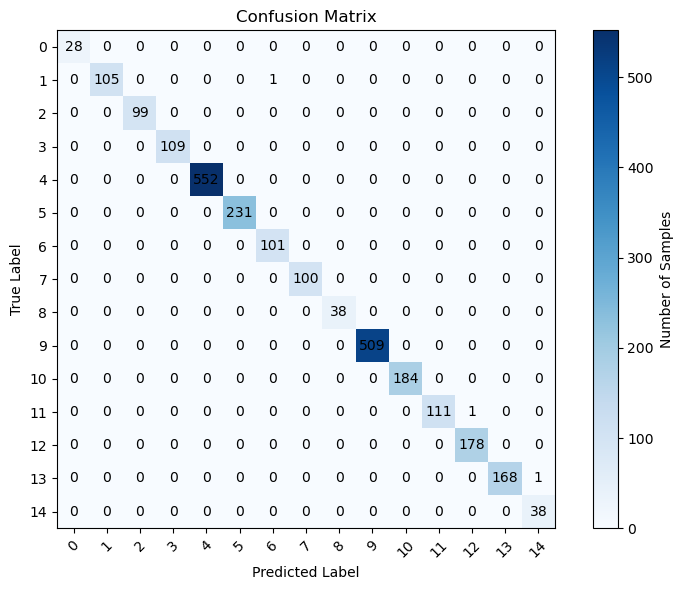

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      0.99      1.00       106
           2       1.00      1.00      1.00        99
           3       1.00      1.00      1.00       109
           4       1.00      1.00      1.00       552
           5       1.00      1.00      1.00       231
           6       0.99      1.00      1.00       101
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00        38
           9       1.00      1.00      1.00       509
          10       1.00      1.00      1.00       184
          11       1.00      0.99      1.00       112
          12       0.99      1.00      1.00       178
          13       1.00      0.99      1.00       169
          14       0.97      1.00      0.99        38

    accuracy                           1.00      2554
   macro avg       1.00      1.00      1.00      2554
wei

In [20]:
conf_matrix = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center')

plt.title('Confusion Matrix')
plt.colorbar(label='Number of Samples')
plt.xticks(np.arange(len(conf_matrix)), list(set(all_targets)), rotation=45)
plt.yticks(np.arange(len(conf_matrix)), list(set(all_targets)))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

class_report = classification_report(all_targets, all_predictions)
print("Classification Report:")
print(class_report)

c:\Users\patel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\patel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\patel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\patel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

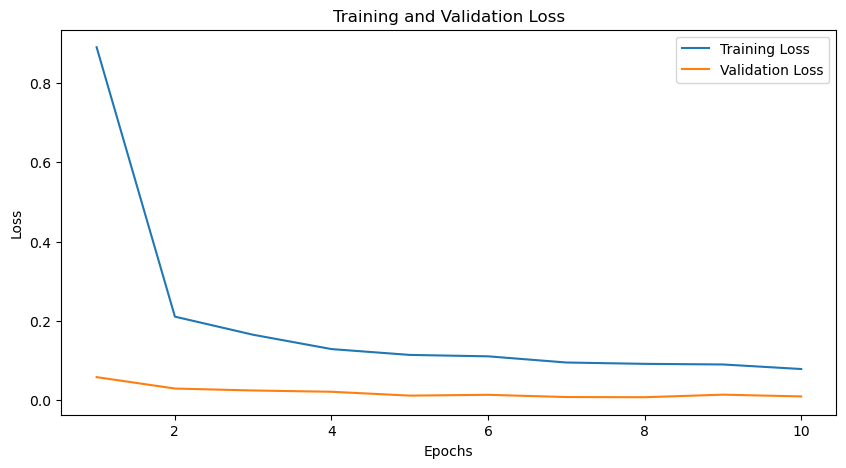

In [21]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, len(train_loss) + 1), y=train_loss, label='Training Loss')
sns.lineplot(x=range(1, len(validation_loss) + 1), y=validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

c:\Users\patel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\patel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\patel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\patel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

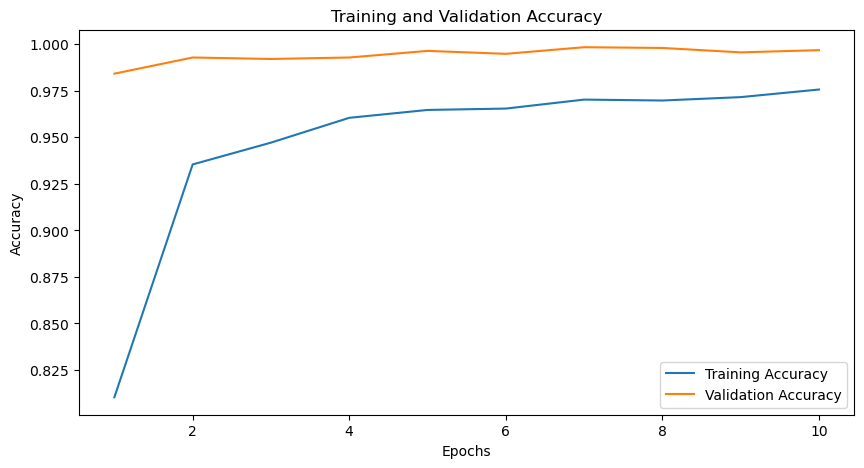

In [22]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, len(train_accuracy) + 1), y=train_accuracy, label='Training Accuracy')
sns.lineplot(x=range(1, len(validation_accuracy) + 1), y=validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [23]:
def extract_features(loader, model, device):
    features = []
    targets = []
    model.eval()
    outputs = None
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            features.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return np.array(features), np.array(targets)

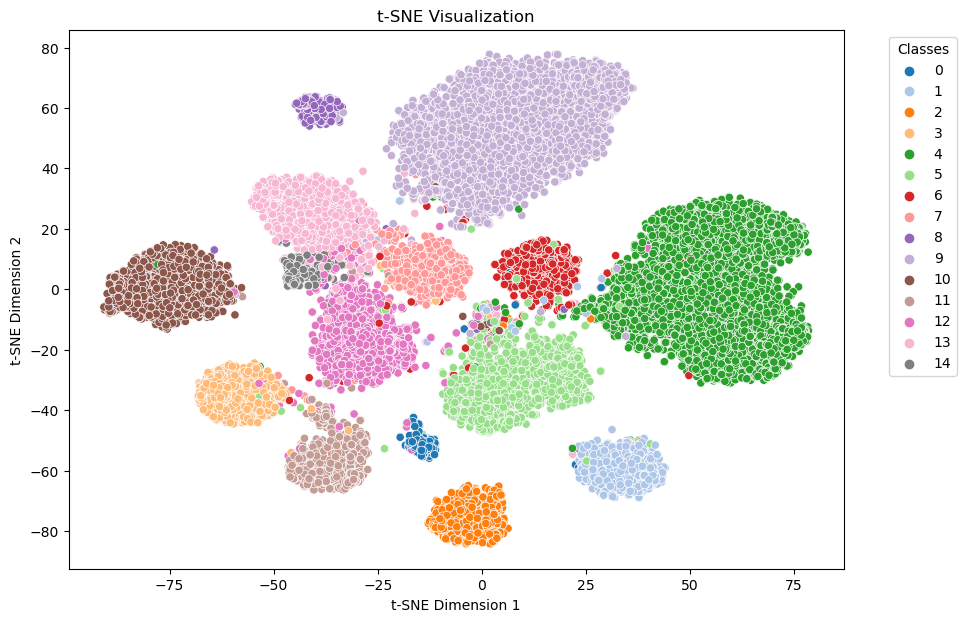

In [24]:
train_features, train_targets = extract_features(train_loader, model, device)
val_features, val_targets = extract_features(val_loader, model, device)

all_features = np.concatenate((train_features, val_features), axis=0)
all_targets = np.concatenate((train_targets, val_targets), axis=0)

tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(all_features)


plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=all_targets, palette='tab20', legend='full')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
